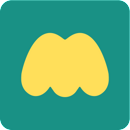

# Modak - data engineer challenge

## 1. Libs

In [51]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 640x480 with 0 Axes>

## 2. Data loading

In [25]:
allowance_backend_table = pd.read_csv('data/allowance_backend_table.csv')
allowance_backend_table.head()

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
0,30f4e25e-3e37-462e-8c3c-42f24f54350f,1724838709,monthly,fifteenth_day,2024-10-15T08:00:41.445627563Z,15,enabled
1,6da398ad-079d-49b9-8668-6d7ce4d22683,1724659829,monthly,fifteenth_day,1724659829,15,enabled
2,2d30fe2d-6c32-4b8a-a19b-906184f64f62,1731309159,monthly,fifteenth_day,1731309159,15,enabled
3,c30180f3-b35c-470c-b25a-f12ec4ce3340,1725414982,monthly,first_day,2024-10-01T08:00:37.516552581Z,1,enabled
4,9f5768db-e953-4057-9fa5-264c46293fbd,1726267511,biweekly,friday,2024-10-02T02:33:10.97923183Z,11,disabled


In [38]:
payment_schedule_backend_table = pd.read_csv('data/payment_schedule_backend_table.csv')
payment_schedule_backend_table.head()

,user_id,payment_date
0,061d8039-b332-40ca-b906-3514b06411c2,22
1,0ca92d01-feed-42e5-b90c-299b615f9d3f,22
2,160bcd2d-3ab0-4a60-9bfa-ccfcc1ee17e4,22
3,1649fee7-c424-4fb7-ac84-db36e15e042a,22
4,1d647703-874d-4744-b4de-6a5212518aa8,22


In [4]:
with open('data/allowance_events.json') as f:
    allowance_events_json = json.load(f)
allowance_events = pd.json_normalize(allowance_events_json)
allowance_events.head()

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
0,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-21 1:39:34,allowance.created,weekly,sunday,10
1,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
2,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
3,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 6:32:28,allowance.created,biweekly,friday,10
4,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 6:32:37,allowance.edited,weekly,friday,10


## 3. Data transformation

In [21]:
def parse_unix_or_date(val):
    """
    Convert a mixed-format value from the updated_at column to a datetime.
    If the value is numeric (or a numeric string), treat it as a Unix timestamp.
    Otherwise, assume it's an ISO-formatted datetime string.
    """
    # Check if the value is a string and represents digits only.
    if isinstance(val, str) and val.isdigit():
        return pd.to_datetime(val, unit='s')
    # If the value is already numeric, convert from Unix timestamp.
    elif isinstance(val, (int, float)):
        return pd.to_datetime(val, unit='s')
    else:
        # Otherwise, attempt to parse as a datetime string.
        return pd.to_datetime(val, errors='coerce', format='ISO8601')

#### Allowance Backend Table (`allowance_backend_table`)  
* Purpose: Stores the current allowance settings for each user, reflecting their 
most recent allowance configuration.  
* Operation:  
  * When a user creates or edits an allowance, this table should be updated 
to reflect the latest `frequency`, `day`, and `next_payment_day`.  
  * The `next_payment_day` field should accurately represent the upcoming 
payment date based on the user's allowance settings.  
  * The allowances get created with the `status` column `enabled`, but the 
users can turn them to `disabled`. Make sure you only use the enabled 
allowances.  
* Potential Issues:  
  * Discrepancies during the affected period may have resulted in incorrect 
`next_payment_day` values in this table.  

In [31]:
allowance_backend_table['creation_date'] = allowance_backend_table['creation_date'].apply(parse_unix_or_date)
allowance_backend_table['updated_at'] = allowance_backend_table['updated_at'].apply(parse_unix_or_date)

allowance_backend_table = allowance_backend_table.sort_values(['creation_date'])

In [35]:
allowance_backend_table.head()

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
1973,7cbedb99-a6d4-45a1-880d-0e661d4b9f75,2024-07-25 18:18:14,biweekly,saturday,2024-11-21 15:25:27.689063932+00:00,30,enabled
1974,c5a7c5f7-6c1e-4ea0-919a-f7efdf4e7cc9,2024-07-25 18:19:09,weekly,friday,2024-08-11 15:29:58.864236548+00:00,16,disabled
1326,c440479e-8cf2-402e-8da9-9c682ea3df39,2024-07-25 18:25:46,biweekly,thursday,2024-11-28 08:00:33.049761141+00:00,12,enabled
798,27602664-335c-4beb-9dd7-7c6942385b64,2024-07-25 18:26:29,weekly,friday,2024-07-26 17:22:16.495657547+00:00,26,disabled
800,d278205f-4175-4dbb-a398-5661a0a9c9f3,2024-07-25 18:26:41,weekly,sunday,2024-12-01 08:01:44.700817530+00:00,8,enabled


In [151]:
allowance_backend_table.describe()

,creation_date,next_payment_day
count,2882,2882.000000
mean,2024-10-09 03:52:12.581193728,12.001388
min,2024-07-25 18:18:14,1.000000
25%,2024-09-13 19:09:55.500000,6.000000
50%,2024-10-09 01:55:00.500000,11.000000
75%,2024-11-09 14:47:20.249999872,18.000000
max,2024-12-03 13:05:56,31.000000
std,NaN,8.583299


#### Payment Schedule Backend Table (`payment_schedule_backend_table`) 
* Purpose: Manages the scheduling of payments to users based on their 
allowance settings.  
* Operation:  
  * Each user should only have one active record in this table at any time. 
  * When a payment is made:  
    * The current record for the user is deleted.  
    * A new record is created with the upcoming payment_date.  
  * The `payment_date` should align with the `next_payment_day` from the 
`allowance_backend_table`.  
  * Users who disable the allowance should not have any active record.  
* Potential Issues: 
  * Errors during the affected period may have resulted in users having  
multiple records or incorrect `payment_date` values in this table.

In [149]:
payment_schedule_backend_table.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_date,2139.0,11.257129,8.212922,1.0,6.0,9.0,15.0,31.0


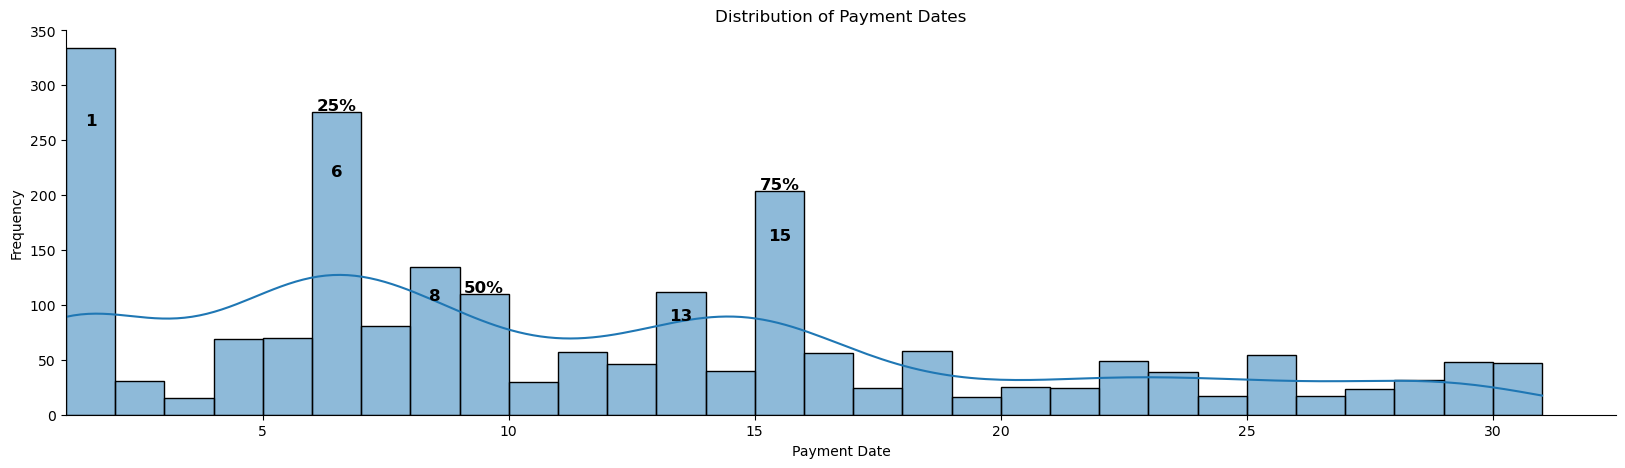

In [121]:
def top_n_payment_dates_plot(payment_schedule_backend_table, top_n=5):
    
    main_observations = list(
        (
            payment_schedule_backend_table["payment_date"]
            .value_counts()
            .nlargest(top_n)
            .index.sort_values()
        )
    )

    # Plot distribution
    plt.figure(figsize=(20, 5))

    ax = sns.histplot(payment_schedule_backend_table["payment_date"], kde=True, bins=30)
    sns.despine(top=True, right=True)
    # Ensure x-axis starts at 0
    plt.xlim(left=1)

    # Add annotations inside the bins for main observation days
    for date in main_observations:
        height = ax.patches[date - 1].get_height()  # Get bin height for annotation
        plt.text(date + 0.5, 
                height * 0.8, 
                str(date), 
                ha="center",
                va="center", 
                fontsize=12, 
                color="black", 
                fontweight="bold")
        
    # Calculate quantiles
    q25, q50, q75 = payment_schedule_backend_table["payment_date"].quantile([0.25, 0.5, 0.75])

    for quantile, label in zip([q25, q50, q75], ["25%", "50%", "75%"]):
        for patch in ax.patches:
            if patch.get_x() <= quantile < patch.get_x() + patch.get_width():
                height = patch.get_height()
                plt.text(quantile + 0.5, 
                        height + 1,  # Slightly above the highest bar
                        label, 
                        ha="center", 
                        fontsize=12, 
                        color="black", 
                        fontweight="bold")
                
    plt.xlabel("Payment Date")
    plt.ylabel("Frequency")
    plt.title("Distribution of Payment Dates")
    plt.show()

top_n_payment_dates_plot(payment_schedule_backend_table)

#### `allowance_events` (JSON)  
This dataset captures the creation and updates of user allowances during the affected 
period.  
* Fields:  
  * `event.name`: The type of event, either `allowance.created` or  
`allowance.edited`.  
  * `event.timestamp`: Timestamp of the event.  
  * `user.id`: Unique identifier for the user.  
  * `allowance.amount`: Allowance amount.  
  * `allowance.scheduled.frequency`: Frequency of the allowance: 
`daily`, `weekly`, `biweekly`, or `monthly`.  
  * `allowance.scheduled.day`:  
    * `"daily"` for daily frequency.  
    * Day of the week for weekly/biweekly schedules.  
    * `"1st"` or `"15th"` for monthly schedules.

In [47]:
allowance_events['event.timestamp'] = allowance_events['event.timestamp'].apply(parse_unix_or_date)

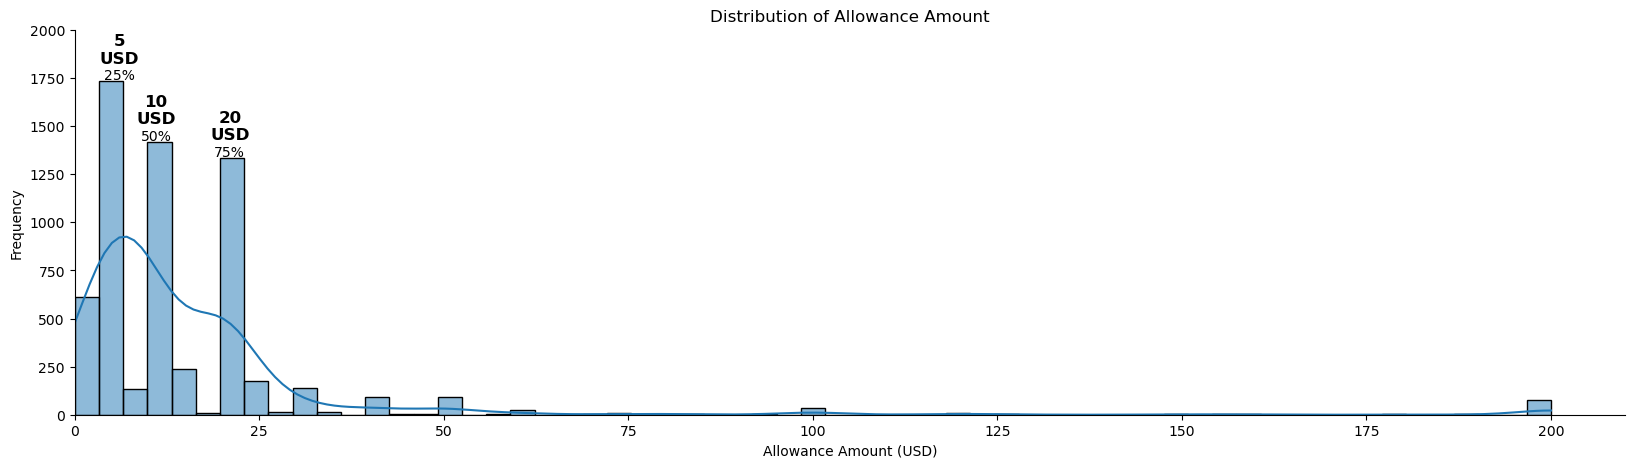

In [138]:
def top_n_allowances_plot(allowance_events, top_n=5):
    
    main_observations = list(
        (
            allowance_events["allowance.amount"]
            .value_counts()
            .nlargest(top_n)
            .index.sort_values()
        )
    )

    # Plot distribution
    plt.figure(figsize=(20, 5))
    ax = sns.histplot(allowance_events["allowance.amount"], 
                      kde=True, 
                      bins=allowance_events["allowance.amount"].unique().size)
    
    # Remove top and right plot borders
    sns.despine(top=True, right=True)

    # Ensure x-axis starts at 0
    plt.xlim(left=0)

    # Adjust y-axis limit to ensure space for annotations
    y_max = ax.get_ylim()[1] * 1.1  # Increase by 10% for better spacing
    plt.ylim(top=y_max)

    # Add annotations inside the bins for main observation allowance amounts
    for idx, val in enumerate(main_observations):
        max_bin_height = max([patch.get_height() for patch in ax.patches if patch.get_x() <= val < patch.get_x() + patch.get_width()], default=0)
        plt.text(val + 1, 
                 max_bin_height + (y_max * 0.04),  # Offset text above the bin
                 f"{val:.0f}\nUSD", 
                 ha="center",
                 va="bottom", 
                 fontsize=12, 
                 color="black", 
                 fontweight="bold")

    # Calculate quantiles
    q25, q50, q75 = allowance_events["allowance.amount"].quantile([0.25, 0.5, 0.75])

    for quantile, label in zip([q25, q50, q75], ["25%", "50%", "75%"]):
        max_bin_height = max([patch.get_height() for patch in ax.patches if patch.get_x() <= quantile < patch.get_x() + patch.get_width()], default=0)
        plt.text(quantile + 1, 
                 max_bin_height + 10, #- (y_max * 0.1),  # Offset text above the bin
                 label, 
                 ha="center", 
                 fontsize=10, 
                 color="black")

    plt.xlabel("Allowance Amount (USD)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Allowance Amount")
    plt.show()

top_n_allowances_plot(allowance_events, top_n=3)

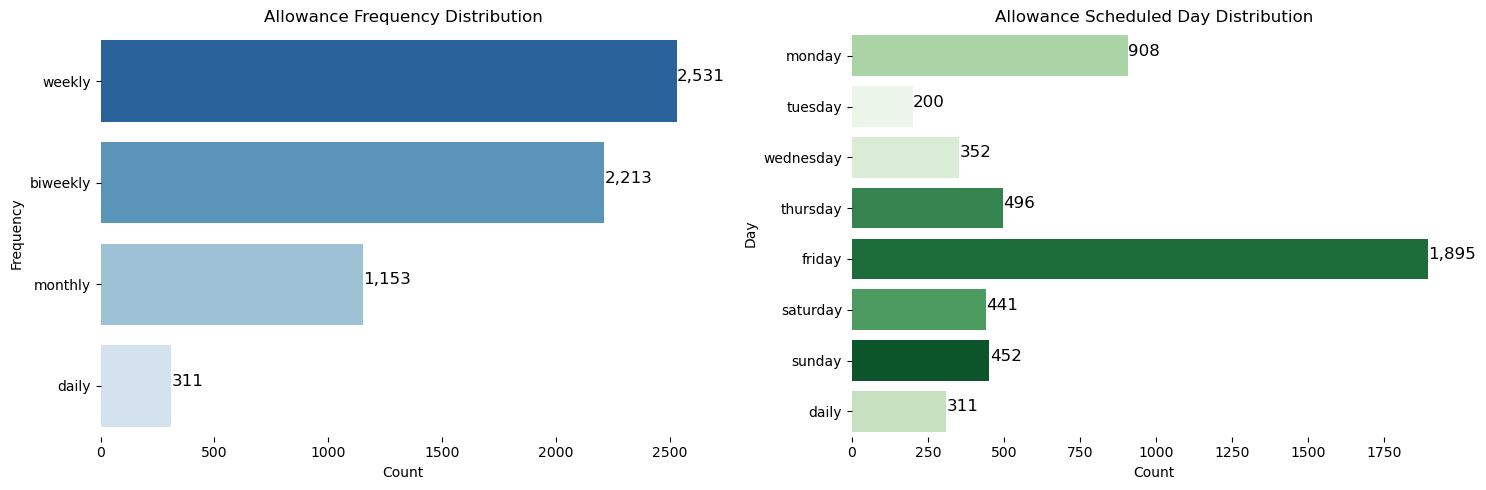

In [145]:
def plot_categorical_variables(allowance_events):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Frequency Plot
    sns.countplot(
        y="allowance.scheduled.frequency",
        data=allowance_events,
        order=allowance_events["allowance.scheduled.frequency"].value_counts().index,
        ax=axes[0],
        palette="Blues_r",
        hue="allowance.scheduled.frequency", 
        legend=False  
    )
    axes[0].set_title("Allowance Frequency Distribution")
    axes[0].set_xlabel("Count")
    axes[0].set_ylabel("Frequency")
    sns.despine(left=True, bottom=True)

    # Annotate frequency bars
    for p in axes[0].patches:
        axes[0].annotate(f"{p.get_width():,.0f}", (p.get_width() + 2, p.get_y() + 0.4), fontsize=12, color="black")

    # Define ordered weekdays
    weekdays_order = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "daily"]

    # Day Plot
    sns.countplot(
        y="allowance.scheduled.day",
        data=allowance_events,
        order=[day for day in weekdays_order if day in allowance_events["allowance.scheduled.day"].unique()],
        ax=axes[1],
        palette="Greens_r",
        hue="allowance.scheduled.day", 
        legend=False  
    )
    axes[1].set_title("Allowance Scheduled Day Distribution")
    axes[1].set_xlabel("Count")
    axes[1].set_ylabel("Day")
    sns.despine(left=True, bottom=True)

    # Annotate day bars
    for p in axes[1].patches:
        axes[1].annotate(f"{p.get_width():,.0f}", (p.get_width() + 2, p.get_y() + 0.4), fontsize=12, color="black")

    plt.tight_layout()
    plt.show()

# Run the function
plot_categorical_variables(allowance_events)

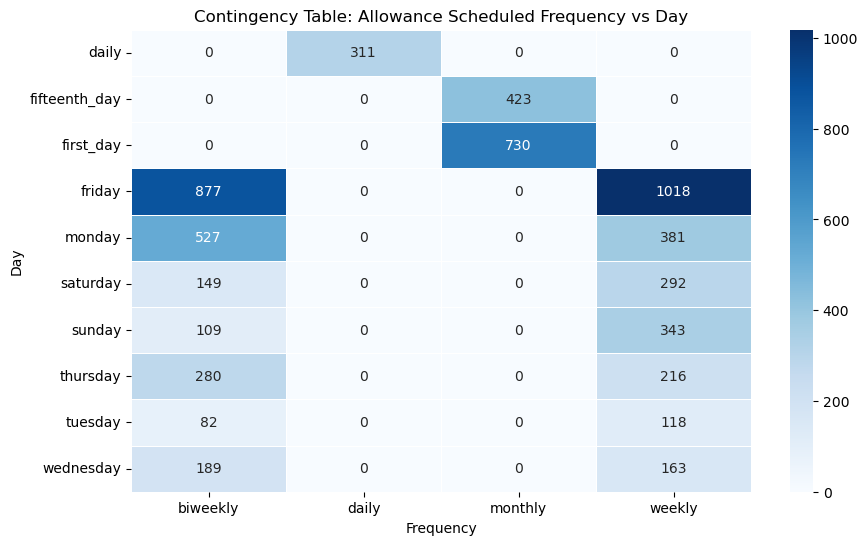

In [148]:
def plot_contingency_table(allowance_events):
    # Create the contingency table
    contingency_table = pd.crosstab(
        allowance_events["allowance.scheduled.day"], 
        allowance_events["allowance.scheduled.frequency"]
    )

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt="d", linewidths=0.5)

    # Titles and labels
    plt.title("Contingency Table: Allowance Scheduled Frequency vs Day")
    plt.xlabel("Frequency")
    plt.ylabel("Day")

    plt.show()

# Run the function
plot_contingency_table(allowance_events)